<a href="https://colab.research.google.com/github/AdamFulton/thesis/blob/main/time_series_cnn_recurrenceplot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import sklearn as sk
import sklearn.metrics.pairwise
from PIL import Image
import torch.nn.functional as f
from torch.utils.data.dataloader import DataLoader
from torchvision import models
from pyts.datasets import load_gunpoint
from pyts.image import GramianAngularField
from mpl_toolkits.axes_grid1 import ImageGrid

%matplotlib inline

In [ ]:
!pip install pyts


     |████████████████████████████████| 2.5 MB 7.8 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
/usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/axes_grid.py:51: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


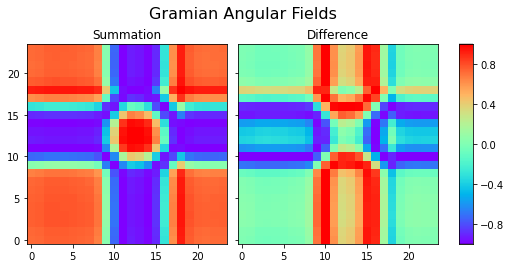

In [ ]:
X, _, _, _ = load_gunpoint(return_X_y=True)

# Transform the time series into Gramian Angular Fields
gasf = GramianAngularField(image_size=24, method='summation')
X_gasf = gasf.fit_transform(X)
gadf = GramianAngularField(image_size=24, method='difference')
X_gadf = gadf.fit_transform(X)

# Show the images for the first time series
fig = plt.figure(figsize=(8, 4))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 2),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.3,
                 )
images = [X_gasf[0], X_gadf[0]]
titles = ['Summation', 'Difference']
for image, title, ax in zip(images, titles, grid):
    im = ax.imshow(image, cmap='rainbow', origin='lower')
    ax.set_title(title, fontdict={'fontsize': 12})
ax.cax.colorbar(im)
ax.cax.toggle_label(True)
plt.suptitle('Gramian Angular Fields', y=0.98, fontsize=16)
plt.show()

In [ ]:
model = models.mobilenet_v3_large(pretrained=True)
model.classifier[3].out_features = 1
model.eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False

In [ ]:
flight_data = sns.load_dataset("flights")
flight_data.head()

dataset = np.random.randint(1,1000, size=(1000,12))
sums = np.zeros(1000,float)


for i in range(0,1000):

  for j in range(0,12):


    sums[i] = sums[i] + dataset[i][j]


In [ ]:
from sklearn.preprocessing import MinMaxScaler
arr = np.array(sums,float)

arr = arr.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
dataset_normalized = scaler.fit_transform(dataset)

sums_normalized = scaler.fit_transform(arr)

In [ ]:
def rec_plot(s, eps=0.01, steps=3):
    d = pdist(s[:,None])
    d = np.floor(d/eps)
    d[d>steps] = steps
    Z = squareform(d)
    return Z

In [ ]:
images = []

for i in dataset_normalized:
  
  df = pd.DataFrame(i, columns = ['0'])
  images.append(rec_plot(df['0']))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


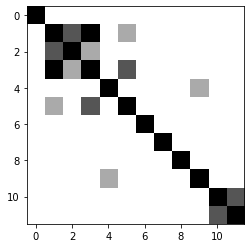

In [ ]:
convert_tensor = transforms.ToTensor()

for i, obj in enumerate(images):
    
  plt.imshow(obj,cmap='gray')
  break

In [ ]:

pil_images = []

for i in images:

  temp = Image.fromarray(i,mode="RGB")
  pil_images.append(temp)

In [ ]:
convert_tensor = transforms.ToTensor()
t = []
for i in pil_images:

  temp = convert_tensor(i)
  t.append(temp)



print(t[0].shape)

torch.Size([3, 12, 12])


In [ ]:
final = []

for i in range(0,len(images)):

  final.append((t[i],sums_normalized))
 

In [ ]:
batch_size = 100

train_dl = DataLoader(final,batch_size)


for i,j in train_dl:

  print(i.shape)
  break

torch.Size([100, 3, 12, 12])


In [ ]:
def get_default_device():

  if torch.cuda.is_available():
    return torch.device("cuda")

  else:
    return torch.device("cpu")

In [ ]:
device = get_default_device();
device

device(type='cuda')

In [ ]:
def to_device(data,device):

  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]

  return data.to(device,non_blocking=True)

In [ ]:
class DeviceDataLoader():
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
       
        return len(self.dl)

In [ ]:
train_dl  = DeviceDataLoader(train_dl,device)
to_device(model,device)

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False

In [ ]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 5

for i in range(epochs):
    correct = 0
    for seq, labels in train_dl:
        optimizer.zero_grad()

       
    
       
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        
        optimizer.step()

    
    
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([100, 1000, 1])) that is different to the input size (torch.Size([100, 1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored